In [22]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [23]:

function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [24]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [25]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [26]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [27]:
function sound(uo::Array{Float64,1},con::Const)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    
    return c
end




sound (generic function with 1 method)

In [28]:
# ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,f,p)=try
#         sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
#     catch
#         println("a2= ",a2,"ρ0 = ", ρ0,"ρ = ",
#             ρ, "Γ0= ",Γ0,"Sxx = ", sxx,μ, "a0 = ", 
#             a0, "f = ",f, "p = ", p)
#     end



In [29]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [30]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end

function WENO3(u::Array{Float64,1},inter::Array{Int,1},ik::Int)
    
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    
    for i in 2:I-1
        
        if inter[i] != inter[i+1] #&& (ik == 4 || ik == 3) 
                
            IS0 = (u[i] - u[i-1])^2
            IS1 = 0  #(u[i+1] - u[i])^2

            c0 = 2/3
            c1 = 1/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uR[i-1] = β0*(u[i]+u[i-1])/2+β1*u[i]
             uR[i-1] = u[i]

            c0 = 1/3
            c1 = 2/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uL[i] = β0*(3u[i]-u[i-1])/2+β1*u[i]
               uL[i] = u[i]
        elseif inter[i] != inter[i-1] #&& (ik == 4 || ik ==3)
            IS0 = 0 # (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
        
            c0 = 2/3
            c1 = 1/3
        
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*u[i]+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*u[i]+β1*(u[i]+u[i+1])/2
          ##  uR[i-1] = u[i]
          #  uL[i] =u[i]
         else
            IS0 = (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
            
            c0 = 2/3
            c1 = 1/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
        end
    end
    return uL,uR
end

WENO3 (generic function with 2 methods)

In [31]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [32]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [33]:
function HLLCEPNew1(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ
            
            conR = con2
            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew1 (generic function with 2 methods)

In [34]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I-1
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
            μL  = con1.μ
            μR  = con2.μ
        end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
    #    if s_star > u[i]
            fL[i,1] = 0
            fL[i,2] = pL_star-sxxL_star
            fL[i,3] = (pL_star-sxxL_star)*s_star
            fL[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
  #      else
            fR[i,1] = 0
            fR[i,2] = pR_star-sxxR_star
            fR[i,3] = (pR_star-sxxR_star)*s_star
            fR[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
  #      end
    end
    
          
    return fL,fR, uuh
end
        

HLLCEP (generic function with 2 methods)

In [35]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
    for  i in 1:I-1
           if inter[i] == 1 
            conL = con1
            conR = con1
        else
            conL = con2
            conR = con2
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
       
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[i,:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[i,1] = 0
            fL[i,2] = pLstar-sxxLstar
            fL[i,3] = (pLstar-sxxLstar)*s_star
            fL[i,4] = -4μL/3*s_star
            uuh[i] = s_star
#        else
            fR[i,1] = 0
            fR[i,2] = pRstar-sxxRstar
            fR[i,3] = (pRstar-sxxRstar)*s_star
            fR[i,4] = -4μR/3*s_star
            uuh[i] = s_star
  #      end
    end
    return fL,fR, uuh
end

HLLCEPNew (generic function with 2 methods)

In [36]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::Var=lB,
                rB::Var=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
    if kind_prb == 1      #two_material
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
    
    elseif kind_prb == 2  #piston
         for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
        elseif kind_prb == 3 #Wilskin
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con1)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
        elseif kind_prb == 4 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
        
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [37]:
function Plastic(con::Const,var::Var,ρstar::Float64,LR::Int)
    Y0= con.Y0 
    ρ0 =con.ρ0
    Γ0 =con.Γ0
    μ  =con.μ 
    a0 =con.a0
    s0 =con.s0
        
    ρ = var.ρ
    uu= var.u
    p = var.p
    sxx=var.sxx
    σ = -p+sxx
    
    ue = zeros(Float64,4)       
    ue[1:4] = [ρ, uu, p ,sxx]
       
    tmp = -4μ/3*log(ρstar/ρ) +sxx
    if (abs(sxx) >=2Y0/3 || abs(tmp) < 2Y0/3)
         c = sound(ue,con)
     
        return ρ,uu,p,sxx,σ,c        
    else
        e = PToe(ρ, p, con) 
        if tmp >= 2Y0/3
           hsxx = 2Y0/3
           hρ  = ρ*exp(-Y0/(2μ)+3sxx/(4μ))
        else #if tmp <= -2/3*Y0
           hsxx = -2Y0/3
           hρ  = ρ*exp(Y0/(2μ)+3sxx/(4μ))
        end
       t    = 1/ρ-1/hρ
       c0   = 1/(ρ0*Γ0)
       c1   = a0^2/Γ0
       hp   = (2(c1*fη(hρ,con)+e)-t*(σ+hsxx))/(2c0-t)
       hσ = -hp + hsxx
       if (ρstar > ρ && LR ==1)||(ρstar < ρ && LR ==2)
          huu = uu -sqrt((σ-hσ)*t)
       else
          huu = uu +sqrt((σ-hσ)*t)
       end
       ρ   = hρ
       uu  = huu
       p   = hp
       sxx = hsxx
       σ   = hσ
       ue[1:4] = [ρ,uu,p,sxx]
       c = sound(ue,con)
        return ρ,uu,p,sxx,σ,c 
   end
              
end

Plastic (generic function with 1 method)

In [38]:
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::Var=lB,rB::Var=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for  i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
# #***************2***********************    
    
    f,uuh = Space(uo,inter)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
        
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3**********************   
    f,uuh = Space(uo,inter)
  
   for i in 1:I
       x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
     end
    uo,u = Bound!(uo,u,inter)
    x[1] = x[3] -2dx[3]
    x[I-1] = x[I-2] +dx[I-2]
    x[I]   =  x[I-2]+2*dx[I-2]
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [39]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0 
    it =1
    
   # plt = Plots.plot() 
    while t<tt
# for i in 1:100
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x,inter)
        #if t/(tt/10) > it
        #    it += 1
            println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [40]:
function TwoMatter()
    
    nv = 3
    jx = 500
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=50
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [41]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 1
    nv = problem.nv
    jx = problem.jx
    hL = zeros(Float64,2)
    hr = zeros(Float64,2)
    
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i],inter,i)
        #    uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
     #   hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
        hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
     end
    ik = floor(Int,jx/2)+nv+1
    for i in 2:I-1
        if inter[i] != inter[i+1]
            ik = i
        end
    end
    
    for i in 2:ik 
        f[i,:]= hL[i,:]-hL[i-1,:]
    end
    
    for i in ik+1:I
        f[i,:]= hR[i,:]-hR[i-1,:]
    end
    return f,uuh
end

Space (generic function with 2 methods)

In [42]:
function Piston()
    

    nv = 3
    jx = 800
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=2
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=20.0
    p1=1.e5
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con1)
        inter[i] = 1
    end 
   

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

Piston (generic function with 1 method)

In [43]:
function Wilkins()
    
    nv = 3
    jx = 800
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    kindProblem=3
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

Wilkins (generic function with 1 method)

In [45]:
function Entropy_wave()
    
    nv = 3
    jx = 800
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    kindProblem=4
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=6.e4
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
        global con2 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)#
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    uexact = zeros(Float64,(jx+2nv+1,4))
    
    
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i in  nv+1:jx+nv+1
        inter[i] = 1
            uo[i,1] = ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
            uo[i,2] = u1
            uo[i,3] = 1.1u1^2*ρ1
            uo[i,4] = sxx1*sin(π*(x[i]+x[i-1]))
            u[i,:]=UoTou(uo[i,:],con1)
    end
    
    
    for i in 1:nv
        inter[i] = 1
        uo[i,:] = uo[i+jx,:]
        uo[jx+nv+1+i,:] = uo[nv+1+i,:]
        u[i,:]= UoTou(uo[i,:],con1)
        u[jx+nv+1+i,:] = UoTou(uo[jx+nv+1+i,:],con1)
    end
    
    for i in nv+1:jx+nv+1
        uexact[i,1] = ρ1*(1-0.1sin(2π*((x[i]+x[i-1])/2-u1*tt)))
        uexact[i,2] = u1
        uexact[i,3] = 1.1u1^2*ρ1
        uexact[i,4] = sxx1*sin(2π*((x[i]+x[i-1])/2-u1*tt))
    end
        
    
    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter,uexact
end

Entropy_wave (generic function with 1 method)

In [46]:
uo,u,x,inter = Piston()
uo1,x1 = TimeSolve(uo,x,inter)
#x1[1] = x1[2]-0.001
plot(x1,u)

1.3252193095233308e-7  1.3252193095233308e-7
1.3249736815886636e-7  2.6501929911119946e-7
1.3243774496685598e-7  3.9745704407805545e-7
1.3236001856187985e-7  5.298170626399353e-7
1.3227170459893043e-7  6.620887672388658e-7
1.3218610255801537e-7  7.942748697968811e-7
1.3211313318132434e-7  9.263880029782055e-7
1.320559711996832e-7  1.0584439741778887e-6
1.3201333808756962e-7  1.1904573122654585e-6
1.3198173962979166e-7  1.32243905189525e-6
1.3195736838878876e-7  1.4543964202840387e-6
1.319372783404079e-7  1.5863336986244467e-6
1.3191958839363907e-7  1.7182532870180858e-6
1.3190386430442245e-7  1.8501571513225082e-6
1.3189145928313108e-7  1.9820486106056393e-6
1.3188328992016276e-7  2.113931900525802e-6
1.3187974887580576e-7  2.2458116494016075e-6
1.318799446061319e-7  2.3776915940077393e-6
1.318808003222947e-7  2.5095723943300338e-6
1.3188154856102628e-7  2.64145394289106e-6
1.3188258203662632e-7  2.7733365249276863e-6
1.3188212961523172e-7  2.905218654542918e-6
1.3188089118036914e-7  3

1.3187920482780208e-7  2.532467692261722e-5
1.318792046177846e-7  2.5456556127235003e-5
1.3187920441569583e-7  2.55884353316507e-5
1.318792042211867e-7  2.5720314535871884e-5
1.3187920403368744e-7  2.585219373990557e-5
1.3187920385244902e-7  2.598407294375802e-5
1.318792036765945e-7  2.6115952147434613e-5
1.3187920350517395e-7  2.6247831350939788e-5
1.3187920333722058e-7  2.637971055427701e-5
1.3187920317180465e-7  2.6511589757448814e-5
1.318792030080839e-7  2.66434689604569e-5
1.3187920284534823e-7  2.6775348163302246e-5
1.3187920268305664e-7  2.69072273659853e-5
1.3187920252086582e-7  2.7039106568506166e-5
1.3187920235864829e-7  2.7170985770864814e-5
1.3187920219650103e-7  2.7302864973061317e-5
1.3187920203474503e-7  2.7434744175096063e-5
1.3187920187391505e-7  2.7566623376969978e-5
1.318792017147395e-7  2.769850257868472e-5
1.3187920155810834e-7  2.7830381780242826e-5
1.3187920140502916e-7  2.7962260981647854e-5
1.3187920125657393e-7  2.8094140182904427e-5
1.318792011138209e-7  2.82

1.3187919128112255e-7  5.090924106601844e-5
1.3187919124826506e-7  5.1041120257266704e-5
1.3187919121565024e-7  5.117299944848235e-5
1.318791911831816e-7  5.130487863966554e-5
1.3187919115077225e-7  5.143675783081631e-5
1.318791911183493e-7  5.156863702193466e-5
1.318791910858578e-7  5.1700516213020514e-5
1.3187919105326396e-7  5.1832395404073776e-5
1.3187919102055647e-7  5.196427459509433e-5
1.3187919098774705e-7  5.209615378608208e-5
1.3187919095486947e-7  5.222803297703695e-5
1.318791909219778e-7  5.235991216795893e-5
1.3187919088914286e-7  5.249179135884807e-5
1.3187919085644855e-7  5.2623670549704515e-5
1.3187919082398718e-7  5.27555497405285e-5
1.3187919079185353e-7  5.288742893132036e-5
1.3187919076014035e-7  5.30193081220805e-5
1.3187919072893293e-7  5.315118731280943e-5
1.3187919069830443e-7  5.328306650350773e-5
1.3187919066831174e-7  5.341494569417604e-5
1.3187919063899312e-7  5.3546824884815034e-5
1.318791906103656e-7  5.36787040754254e-5
1.3187919058242503e-7  5.3810583266

1.3187918797268192e-7  7.570252864258059e-5
1.3187918796452764e-7  7.583440783054511e-5
1.3187918795639255e-7  7.59662870185015e-5
1.3187918794828645e-7  7.60981662064498e-5
1.318791879402216e-7  7.623004539439002e-5
1.31879187932212e-7  7.636192458232224e-5
1.3187918792427293e-7  7.649380377024651e-5
1.3187918791641924e-7  7.662568295816293e-5
1.3187918790866513e-7  7.675756214607159e-5
1.3187918790102304e-7  7.688944133397261e-5
1.3187918789350263e-7  7.702132052186611e-5
1.3187918788611029e-7  7.715319970975222e-5
1.3187918787884878e-7  7.728507889763107e-5
1.3187918787171697e-7  7.741695808550278e-5
1.3187918786470965e-7  7.75488372733675e-5
1.3187918785781777e-7  7.768071646122531e-5
1.3187918785102904e-7  7.781259564907633e-5
1.3187918784432824e-7  7.794447483692066e-5
1.3187918783769844e-7  7.807635402475836e-5
1.318791878311213e-7  7.820823321258948e-5
1.318791878245785e-7  7.834011240041406e-5
1.3187918781805235e-7  7.847199158823211e-5
1.3187918781152705e-7  7.860387077604364

1.318791870635404e-7  0.0001018146077535904
1.318791870610721e-7  0.00010194648694065147
1.3187918705861135e-7  0.00010207836612771008
1.3187918705615654e-7  0.00010221024531476623
1.3187918705370687e-7  0.00010234212450181994
1.318791870512615e-7  0.0001024740036888712
1.318791870488205e-7  0.00010260588287592002
1.3187918704638395e-7  0.0001027377620629664
1.318791870439525e-7  0.00010286964125001036
1.3187918704152712e-7  0.00010300152043705189
1.318791870391091e-7  0.000103133399624091
1.3187918703669953e-7  0.00010326527881112769
1.318791870342998e-7  0.00010339715799816198
1.3187918703191112e-7  0.0001035290371851939
1.3187918702953459e-7  0.00010366091637222343
1.318791870271711e-7  0.0001037927955592506
1.3187918702482127e-7  0.00010392467474627542
1.3187918702248545e-7  0.00010405655393329791
1.318791870201635e-7  0.00010418843312031807
1.318791870178552e-7  0.00010432031230733592
1.3187918701555976e-7  0.00010445219149435149
1.3187918701327664e-7  0.00010458407068136476
1.318

1.3187918674190308e-7  0.00012634413651367062
1.3187918674063378e-7  0.00012647601570041125
1.3187918673936736e-7  0.00012660789488715062
1.3187918673810417e-7  0.00012673977407388874
1.318791867368449e-7  0.00012687165326062558
1.3187918673558983e-7  0.00012700353244736117
1.318791867343395e-7  0.00012713541163409552
1.3187918673309426e-7  0.00012726729082082863
1.318791867318545e-7  0.00012739917000756048
1.3187918673062047e-7  0.0001275310491942911
1.3187918672939254e-7  0.00012766292838102048
1.3187918672817104e-7  0.00012779480756774865
1.3187918672695602e-7  0.0001279266867544756
1.3187918672574797e-7  0.00012805856594120136
1.318791867245468e-7  0.0001281904451279259
1.3187918672335274e-7  0.00012832232431464924
1.3187918672216615e-7  0.00012845420350137142
1.3187918672098732e-7  0.0001285860826880924
1.318791867198165e-7  0.00012871796187481223
1.3187918671865372e-7  0.00012884984106153089
1.3187918671749956e-7  0.00012898172024824838
1.3187918671635416e-7  0.000129113599434964

([8973.45 20.0 6.83257e8 -5.84339e7; 8973.45 20.0 6.83257e8 -5.84339e7; … ; 8930.0 -5.19312e-14 100000.0 -0.0123127; 8930.0 -8.18449e-14 100000.0 0.0123116], [-0.000746479, 0.0005, 0.00174648, 0.00299043, 0.00423438, 0.00547831, 0.00672226, 0.0079662, 0.00921015, 0.0104541  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, 1.0025, 1.00375])

In [47]:
uo,u,x,inter,uexact = Entropy_wave()
uo2,x2 = TimeSolve(uo,x,inter)

4.801268050080046e-9  4.801268050080046e-9
4.80126771055515e-9  9.602535760635197e-9
4.801267505295039e-9  1.4403803265930237e-8
4.801267381830903e-9  1.920507064776114e-8
4.801267309981083e-9  2.4006337957742223e-8
4.801267271297802e-9  2.8807605229040024e-8
4.801267253048099e-9  3.360887248208812e-8
4.8012672450843025e-9  3.8410139727172424e-8
4.801267239727033e-9  4.321140696689946e-8
4.801267232722364e-9  4.801267419962182e-8
4.80126722239088e-9  5.28139414220127e-8
4.801267210618202e-9  5.7615208632630906e-8
4.801267199109991e-9  6.24164758317409e-8
4.801267191445226e-9  6.721774302318613e-8
4.801267188400939e-9  7.201901021158707e-8
4.80126718891519e-9  7.682027740050227e-8
4.801267190284837e-9  8.16215445907871e-8
4.8012671913445635e-9  8.642281178213166e-8
4.80126719190841e-9  9.122407897404007e-8
4.801267191747922e-9  9.6025346165788e-8
4.8012671908826e-9  1.008266133566706e-7
4.801267189492167e-9  1.0562788054616277e-7
4.801267188755619e-9  1.1042914773491839e-7
4.80126718882

4.80126718965378e-9  9.17042035624896e-7
4.801267189650755e-9  9.218433028145468e-7
4.801267189647737e-9  9.266445700041945e-7
4.801267189645161e-9  9.314458371938396e-7
4.801267189641557e-9  9.362471043834812e-7
4.801267189638544e-9  9.410483715731197e-7
4.8012671896349946e-9  9.458496387627547e-7
4.80126718963249e-9  9.506509059523872e-7
4.8012671896295674e-9  9.554521731420168e-7
4.80126718962708e-9  9.60253440331644e-7
4.801267189623638e-9  9.650547075212675e-7
4.801267189620643e-9  9.69855974710888e-7
4.801267189618136e-9  9.74657241900506e-7
4.8012671896142125e-9  9.794585090901203e-7
4.801267189611367e-9  9.842597762797316e-7
4.801267189608452e-9  9.890610434693401e-7
4.801267189605397e-9  9.938623106589455e-7
4.801267189601867e-9  9.986635778485474e-7
4.801267189599305e-9  1.0034648450381466e-6
4.801267189596052e-9  1.0082661122277426e-6
4.8012671895929324e-9  1.0130673794173355e-6
4.801267189589786e-9  1.0178686466069254e-6
4.801267189585735e-9  1.022669913796511e-6
4.80126718

4.801267188853899e-9  1.8388853359689542e-6
4.801267188847851e-9  1.843686603157802e-6
4.801267188842488e-9  1.8484878703466446e-6
4.801267188837576e-9  1.8532891375354821e-6
4.801267188831043e-9  1.858090404724313e-6
4.801267188825133e-9  1.8628916719131383e-6
4.801267188819292e-9  1.8676929391019576e-6
4.8012671888139616e-9  1.8724942062907716e-6
4.801267188807597e-9  1.8772954734795793e-6
4.801267188802435e-9  1.8820967406683816e-6
4.8012671887966396e-9  1.8868980078571782e-6
4.8012671887912025e-9  1.8916992750459694e-6
4.801267188785794e-9  1.8965005422347552e-6
4.80126718877986e-9  1.9013018094235351e-6
4.801267188774518e-9  1.9061030766123097e-6
4.801267188769504e-9  1.9109043438010793e-6
4.8012671887629386e-9  1.9157056109898422e-6
4.801267188757522e-9  1.9205068781785997e-6
4.801267188751465e-9  1.9253081453673512e-6
4.801267188747041e-9  1.930109412556098e-6
4.8012671887416726e-9  1.93491067974484e-6
4.8012671887358195e-9  1.9397119469335757e-6
4.801267188729933e-9  1.94451321

4.801267187548154e-9  2.7751324376752802e-6
4.801267187540543e-9  2.779933704862821e-6
4.801267187533232e-9  2.784734972050354e-6
4.801267187525358e-9  2.7895362392378795e-6
4.801267187517464e-9  2.794337506425397e-6
4.8012671875095614e-9  2.7991387736129062e-6
4.801267187500699e-9  2.803940040800407e-6
4.801267187492911e-9  2.8087413079879e-6
4.8012671874845136e-9  2.8135425751753843e-6
4.8012671874766454e-9  2.818343842362861e-6
4.801267187468232e-9  2.8231451095503293e-6
4.801267187459659e-9  2.827946376737789e-6
4.801267187451263e-9  2.8327476439252405e-6
4.801267187442297e-9  2.837548911112683e-6
4.801267187433982e-9  2.842350178300117e-6
4.801267187426158e-9  2.8471514454875432e-6
4.801267187418392e-9  2.8519527126749615e-6
4.801267187409521e-9  2.856753979862371e-6
4.8012671874022505e-9  2.861555247049773e-6
4.801267187394846e-9  2.866356514237168e-6
4.801267187387477e-9  2.8711577814245556e-6
4.801267187379255e-9  2.875959048611935e-6
4.801267187371333e-9  2.880760315799306e-6


4.801267185743122e-9  3.7161808062648292e-6
4.801267185731899e-9  3.720982073450561e-6
4.80126718572164e-9  3.7257833406362828e-6
4.801267185710838e-9  3.7305846078219935e-6
4.801267185700581e-9  3.735385875007694e-6
4.80126718568917e-9  3.740187142193383e-6
4.801267185678829e-9  3.744988409379062e-6
4.801267185667433e-9  3.7497896765647295e-6
4.801267185657609e-9  3.7545909437503872e-6
4.801267185646724e-9  3.759392210936034e-6
4.8012671856358526e-9  3.7641934781216697e-6
4.801267185624984e-9  3.768994745307295e-6
4.8012671856142565e-9  3.773796012492909e-6
4.801267185603425e-9  3.7785972796785125e-6
4.80126718559265e-9  3.783398546864105e-6
4.801267185581272e-9  3.788199814049686e-6
4.801267185569597e-9  3.7930010812352557e-6
4.801267185559384e-9  3.797802348420815e-6
4.801267185549081e-9  3.802603615606364e-6
4.80126718553882e-9  3.807404882791903e-6
4.801267185528641e-9  3.8122061499774314e-6
4.801267185518405e-9  3.81700741716295e-6
4.801267185507607e-9  3.821808684348458e-6
4.801

4.801267183382275e-9  4.681235510369414e-6
4.801267183369159e-9  4.6860367775527834e-6
4.801267183357009e-9  4.690838044736141e-6
4.801267183344797e-9  4.695639311919485e-6
4.801267183331711e-9  4.700440579102817e-6
4.8012671833184895e-9  4.705241846286135e-6
4.8012671833053465e-9  4.710043113469441e-6
4.801267183291287e-9  4.714844380652732e-6
4.8012671832785806e-9  4.71964564783601e-6
4.801267183266867e-9  4.724446915019277e-6
4.8012671832542424e-9  4.729248182202531e-6
4.8012671832408975e-9  4.734049449385772e-6
4.801267183228232e-9  4.738850716569e-6
4.801267183214915e-9  4.743651983752215e-6
4.801267183200511e-9  4.748453250935416e-6
4.8012671831867015e-9  4.753254518118603e-6
4.8012671831730414e-9  4.758055785301776e-6
4.8012671831598115e-9  4.762857052484936e-6
4.801267183147108e-9  4.767658319668083e-6
4.801267183133463e-9  4.772459586851217e-6
4.801267183120343e-9  4.777260854034337e-6
4.801267183106565e-9  4.782062121217443e-6
4.801267183093367e-9  4.786863388400537e-6
4.8012

([2699.25 800.0 1.96065e9 15524.7; 2699.15 800.0 1.96065e9 15547.2; … ; 2784.78 800.0 1.96063e9 2926.22; 2784.67 800.0 1.96063e9 2949.98], [0.00384375, 0.00390625, 0.00396875, 0.00403125, 0.00409375, 0.00415625, 0.00421875, 0.00428125, 0.00434375, 0.00440625  …  0.0536562, 0.0537187, 0.0537812, 0.0538437, 0.0539062, 0.0539687, 0.0540312, 0.0540937, 0.0541562, 0.0542187])

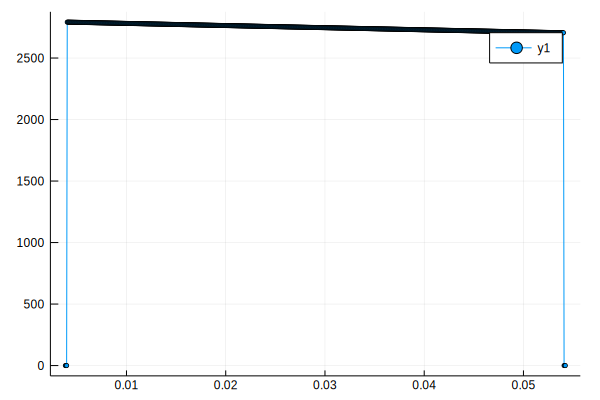

In [53]:
using Plots
plot(x2,uexact[:,1],marker=2)

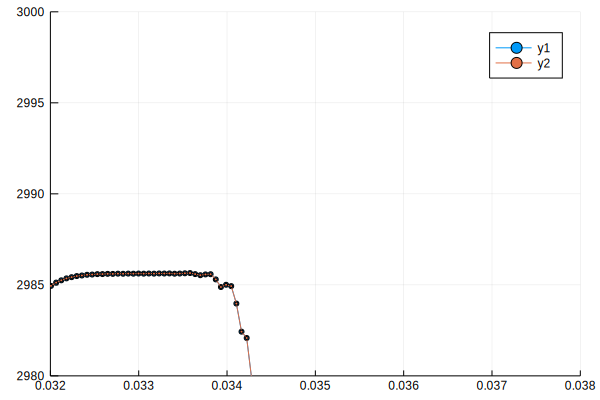

In [363]:
plot(x3,uo3[:,1],marker = 3)
plot!(x2,uo2[:,1],marker = 2,xlims = (0.032,0.038),ylims = (2980,3000))

In [326]:
uo,u,x,inter = Piston()
uo2,x2 = TimeSolve(uo,x,inter)

1.3252193095233308e-7  1.3252193095233308e-7
1.3249736815886636e-7  2.6501929911119946e-7
1.3243774496685598e-7  3.9745704407805545e-7
1.3236001856187985e-7  5.298170626399353e-7
1.3227170459893043e-7  6.620887672388658e-7
1.3218610255801537e-7  7.942748697968811e-7
1.3211313318132434e-7  9.263880029782055e-7
1.320559711996832e-7  1.0584439741778887e-6
1.3201333808756962e-7  1.1904573122654585e-6
1.3198173962979166e-7  1.32243905189525e-6
1.3195736838878876e-7  1.4543964202840387e-6
1.319372783404079e-7  1.5863336986244467e-6
1.3191958839363907e-7  1.7182532870180858e-6
1.3190386430442245e-7  1.8501571513225082e-6
1.3189145928313108e-7  1.9820486106056393e-6
1.3188328992016276e-7  2.113931900525802e-6
1.3187974887580576e-7  2.2458116494016075e-6
1.318799446061319e-7  2.3776915940077393e-6
1.318808003222947e-7  2.5095723943300338e-6
1.3188154856102628e-7  2.64145394289106e-6
1.3188258203662632e-7  2.7733365249276863e-6
1.3188212961523172e-7  2.905218654542918e-6
1.3188089118036914e-7  3

1.3187920574542408e-7  2.4797160101966637e-5
1.3187920550516176e-7  2.49290393074718e-5
1.318792052717682e-7  2.5060918512743566e-5
1.318792050458487e-7  2.5192797717789417e-5
1.3187920482780208e-7  2.532467692261722e-5
1.318792046177846e-7  2.5456556127235003e-5
1.3187920441569583e-7  2.55884353316507e-5
1.318792042211867e-7  2.5720314535871884e-5
1.3187920403368744e-7  2.585219373990557e-5
1.3187920385244902e-7  2.598407294375802e-5
1.318792036765945e-7  2.6115952147434613e-5
1.3187920350517395e-7  2.6247831350939788e-5
1.3187920333722058e-7  2.637971055427701e-5
1.3187920317180465e-7  2.6511589757448814e-5
1.318792030080839e-7  2.66434689604569e-5
1.3187920284534823e-7  2.6775348163302246e-5
1.3187920268305664e-7  2.69072273659853e-5
1.3187920252086582e-7  2.7039106568506166e-5
1.3187920235864829e-7  2.7170985770864814e-5
1.3187920219650103e-7  2.7302864973061317e-5
1.3187920203474503e-7  2.7434744175096063e-5
1.3187920187391505e-7  2.7566623376969978e-5
1.318792017147395e-7  2.7698

1.3187919148865343e-7  5.011796591782349e-5
1.3187919145243647e-7  5.024984510927593e-5
1.3187919141695103e-7  5.038172430069288e-5
1.3187919138215047e-7  5.051360349207503e-5
1.3187919134796867e-7  5.0645482683422996e-5
1.3187919131432378e-7  5.077736187473732e-5
1.3187919128112255e-7  5.090924106601844e-5
1.3187919124826506e-7  5.1041120257266704e-5
1.3187919121565024e-7  5.117299944848235e-5
1.318791911831816e-7  5.130487863966554e-5
1.3187919115077225e-7  5.143675783081631e-5
1.318791911183493e-7  5.156863702193466e-5
1.318791910858578e-7  5.1700516213020514e-5
1.3187919105326396e-7  5.1832395404073776e-5
1.3187919102055647e-7  5.196427459509433e-5
1.3187919098774705e-7  5.209615378608208e-5
1.3187919095486947e-7  5.222803297703695e-5
1.318791909219778e-7  5.235991216795893e-5
1.3187919088914286e-7  5.249179135884807e-5
1.3187919085644855e-7  5.2623670549704515e-5
1.3187919082398718e-7  5.27555497405285e-5
1.3187919079185353e-7  5.288742893132036e-5
1.3187919076014035e-7  5.3019308

1.3187918794828645e-7  7.60981662064498e-5
1.318791879402216e-7  7.623004539439002e-5
1.31879187932212e-7  7.636192458232224e-5
1.3187918792427293e-7  7.649380377024651e-5
1.3187918791641924e-7  7.662568295816293e-5
1.3187918790866513e-7  7.675756214607159e-5
1.3187918790102304e-7  7.688944133397261e-5
1.3187918789350263e-7  7.702132052186611e-5
1.3187918788611029e-7  7.715319970975222e-5
1.3187918787884878e-7  7.728507889763107e-5
1.3187918787171697e-7  7.741695808550278e-5
1.3187918786470965e-7  7.75488372733675e-5
1.3187918785781777e-7  7.768071646122531e-5
1.3187918785102904e-7  7.781259564907633e-5
1.3187918784432824e-7  7.794447483692066e-5
1.3187918783769844e-7  7.807635402475836e-5
1.318791878311213e-7  7.820823321258948e-5
1.318791878245785e-7  7.834011240041406e-5
1.3187918781805235e-7  7.847199158823211e-5
1.3187918781152705e-7  7.860387077604364e-5
1.3187918780498907e-7  7.873574996384863e-5
1.3187918779842803e-7  7.886762915164706e-5
1.3187918779183727e-7  7.89995083394389

1.3187918707606335e-7  0.0001011552118182478
1.3187918707352736e-7  0.00010128709100532133
1.318791870710092e-7  0.00010141897019239234
1.318791870685068e-7  0.00010155084937946084
1.318791870660179e-7  0.00010168272856652686
1.318791870635404e-7  0.0001018146077535904
1.318791870610721e-7  0.00010194648694065147
1.3187918705861135e-7  0.00010207836612771008
1.3187918705615654e-7  0.00010221024531476623
1.3187918705370687e-7  0.00010234212450181994
1.318791870512615e-7  0.0001024740036888712
1.318791870488205e-7  0.00010260588287592002
1.3187918704638395e-7  0.0001027377620629664
1.318791870439525e-7  0.00010286964125001036
1.3187918704152712e-7  0.00010300152043705189
1.318791870391091e-7  0.000103133399624091
1.3187918703669953e-7  0.00010326527881112769
1.318791870342998e-7  0.00010339715799816198
1.3187918703191112e-7  0.0001035290371851939
1.3187918702953459e-7  0.00010366091637222343
1.318791870271711e-7  0.0001037927955592506
1.3187918702482127e-7  0.00010392467474627542
1.31879

1.318791867521026e-7  0.00012528910301969965
1.3187918675082679e-7  0.00012542098220645048
1.318791867495507e-7  0.00012555286139320003
1.318791867482745e-7  0.00012568474057994832
1.3187918674699843e-7  0.00012581661976669532
1.3187918674572278e-7  0.00012594849895344106
1.3187918674444804e-7  0.00012608037814018552
1.318791867431747e-7  0.0001262122573269287
1.3187918674190308e-7  0.00012634413651367062
1.3187918674063378e-7  0.00012647601570041125
1.3187918673936736e-7  0.00012660789488715062
1.3187918673810417e-7  0.00012673977407388874
1.318791867368449e-7  0.00012687165326062558
1.3187918673558983e-7  0.00012700353244736117
1.318791867343395e-7  0.00012713541163409552
1.3187918673309426e-7  0.00012726729082082863
1.318791867318545e-7  0.00012739917000756048
1.3187918673062047e-7  0.0001275310491942911
1.3187918672939254e-7  0.00012766292838102048
1.3187918672817104e-7  0.00012779480756774865
1.3187918672695602e-7  0.0001279266867544756
1.3187918672574797e-7  0.0001280585659412013

([8973.45 20.0 6.83257e8 -5.84339e7; 8973.45 20.0 6.83257e8 -5.84339e7; … ; 8930.0 -5.19312e-14 100000.0 -0.0123127; 8930.0 -8.18449e-14 100000.0 0.0123116], [-0.000746479, 0.0005, 0.00174648, 0.00299043, 0.00423438, 0.00547831, 0.00672226, 0.0079662, 0.00921015, 0.0104541  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, 1.0025, 1.00375])

In [328]:
uo2

807×4 Array{Float64,2}:
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.44  20.0               6.8207e8   -5.96211e7
 8973.52  20.0               6.83123e8  -5.85682e7
 8973.45  20.0               6.8197e8   -5.97212e7
 8973.5   20.0               6.82665e8  -5.90261e7
 8973.45  20.0               6.81863e8  -5.98282e7
 8973.48  20.0               6.82274e8  -5.94167e7
 8973.45  20.0               6.81809e8  -5.98823e7
 8973.46  20.0               6.81999e8  -5.96919e7
 8973.45  20.0               6.818e8    -5.98915e7
    ⋮                                             
 8930.0    2.39121e-13  100000.0         0.0123093
 8930.0    2.07594e-13  100000.0        -0.012315 
 8930.0    1.87083e-13  100000.0         0.0123104
 8930.0    1.54432e-13  100000.0         0.0123107
 8930.0    1.11609e-13  100000.0        -0.024626 
 8930.0

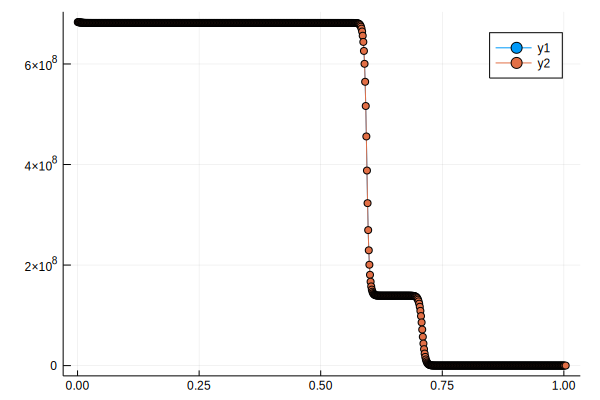

In [316]:
plot(x1,uo1[:,3],marker=1)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))
plot!(x2,uo2[:,3],marker=4)

In [293]:
uo,u,x,inter = TwoMatter()
#plot(x,uo[:,1])
#plot!(x,inter
#uo1,x1 = TimeSolve(uo,x,inter)
uo2,x2 = TimeSolve(uo,x,inter)
#uo

250
7.752056446453582e-9  7.752056446453582e-9
7.734597057403835e-9  1.5486653503857417e-8
7.724525945701223e-9  2.321117944955864e-8
7.719033591586771e-9  3.093021304114541e-8
7.716093963423798e-9  3.864630700456921e-8
7.714569694005609e-9  4.636087669857482e-8
7.713808669324152e-9  5.4074685367898975e-8
7.713437119529542e-9  6.178812248742851e-8
7.71324437664168e-9  6.95013668640702e-8
7.71311499628102e-9  7.721448186035121e-8
7.71298907881725e-9  8.492747093916845e-8
7.712839400085955e-9  9.26403103392544e-8
7.712659464831941e-9  1.0035296980408634e-7
7.712457344748723e-9  1.0806542714883507e-7
7.712252409913436e-9  1.157776795587485e-7
7.712070624235784e-9  1.2348975018298429e-7
7.711936489636813e-9  1.312016866726211e-7
7.711827742201542e-9  1.3891351441482264e-7
7.711748527750863e-9  1.466252629425735e-7
7.711718285971109e-9  1.543369812285446e-7
7.711725854690686e-9  1.620487070832353e-7
7.71170532230364e-9  1.6976041240553893e-7
7.711705410748197e-9  1.7747211781628712e-7
7.711

([8930.0 50.0 0.000646488 -5.14458e-5; 8930.0 50.0 0.000646488 -5.14458e-5; … ; 2785.0 -1.69049e-11 0.0109717 0.0108267; 2785.0 -2.45102e-11 1.00003e-12 -0.000191184], [NaN, -0.000161436, -6.1436e-5, 3.8564e-5, 0.000138564, 0.000238564, 0.000338564, 0.000438564, 0.000538564, 0.000638564  …  0.0494, 0.0495, 0.0496, 0.0497, 0.0498, 0.0499, 0.05, 0.0501, NaN, 0.0503])

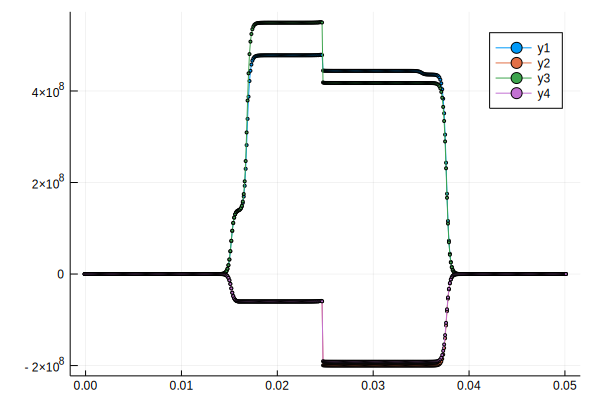

In [247]:
plot(x1,uo1[:,3:4],marker=2)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))
plot!(x2,uo2[:,3:4],marker=2)

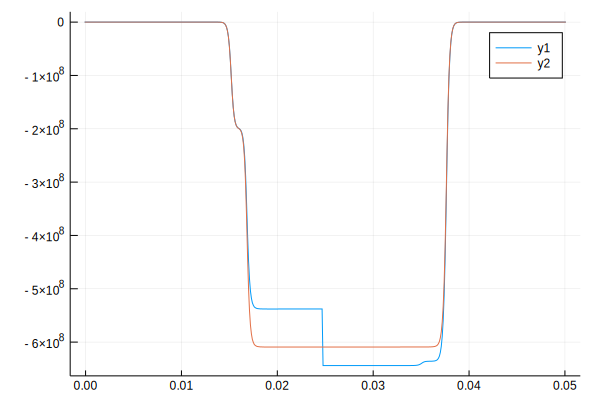

In [255]:
plot(x1,-uo1[:,3]+uo1[:,4])
plot!(x2,-uo2[:,3]+uo2[:,4])

In [111]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end

@time HLLCEP(uo[:,2],uL,uR,inter)
@time HLLCEPNew(uo[:,2],uL,uR,inter)
@time HLLCEPNew1(uo[:,2],uL,uR,inter)

250
  0.000174 seconds (4.57 k allocations: 190.844 KiB)
  0.001129 seconds (56.38 k allocations: 1000.328 KiB)
  0.000857 seconds (44.31 k allocations: 1.026 MiB)


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])

In [181]:
using Pkg

In [1]:
#ue = zeros(Float64,4)
ue[1:4] = [1, 2, 3 ,4]

LoadError: UndefVarError: ue not defined

In [86]:
function test(c)
    if c^2 < 2
        return c
    else
        for i in 1:100000
            c += sqrt(0.01*c)*exp(0.1*c)-sin(c)
        end
    end
    return c
end
function test1(c)
    if c^2 < 2
        return c
    end
end
@time test(1)
@time test(0.2)
@time test(2)
@time test(3)
@time test(0.5)
@time test1(1)
@time test1(0.2)
@time test1(2)
@time test1(3)
@time test1(0.5)

  0.014499 seconds (34.22 k allocations: 1.789 MiB)
  0.008761 seconds (21.92 k allocations: 1.171 MiB)
  0.002532 seconds (5 allocations: 176 bytes)
  0.003133 seconds (5 allocations: 176 bytes)
  0.000002 seconds (5 allocations: 176 bytes)
  0.004922 seconds (1.96 k allocations: 107.191 KiB)
  0.005580 seconds (8.06 k allocations: 453.139 KiB)
  0.000003 seconds (4 allocations: 160 bytes)
  0.000002 seconds (4 allocations: 160 bytes)
  0.000002 seconds (5 allocations: 176 bytes)


0.5

In [130]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end
HLLCEPNew(uo[:,2],uL,uR,inter)

250


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])